In [ ]:
# Vergleich der Berliner Fahrradzählstellendaten mit Db Rad+ Zähldaten auf den Segmenten parallel zu den Zählstellen
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

In [12]:
# Schritt 1 (nur einmal anfangs, wenn nötig): VERSCHNEIDEN der DBRP Daten mit Buffern um die Zählstellen, Aufschlüsseln nach Zeitraum, aggregieren nach Zählstelle, parquet-export

import pandas as pd
import geopandas as gpd
from shapely import wkt
import pyarrow as pa
import pyarrow.parquet as pq
import time

# Start timing
start_time = time.time()

# Step 1: Define the file paths
parquet_file = "data/network_all_months_plus_25833_length_with_fahrradstrasse.parquet"
buffer_file = "data/Buffers_FZS_25833.geojson"
output_file = "data/fzs_with_networkdata.parquet"

# Step 2: Get only the needed columns
print("Reading parquet schema...")
parquet_schema = pq.read_schema(parquet_file)
all_columns = parquet_schema.names

# Filter for needed columns - only id and route_count columns
columns_to_load = ["id"]
route_count_columns = [col for col in all_columns if col.endswith("_route_count")]
columns_to_load += route_count_columns

print(f"Found {len(route_count_columns)} route_count columns")

# Step 3: Load the buffer file first (it's smaller)
print("Loading buffer file...")
gdf_buffers = gpd.read_file(buffer_file)
# Keep only the needed columns from buffers
gdf_buffers = gdf_buffers[['geometry', 'Zählstelle', 'Beschreibung - Fahrtrichtung', 'Installationsdatum']]
print(f"Loaded {len(gdf_buffers)} buffer polygons")

# Step 4: Process the parquet file in batches using PyArrow directly
print("Processing parquet in batches...")

# Function to process each batch and find intersections with buffers
def process_batch_with_intersection(batch_df):
    # We still need geometry for the spatial join, then we'll drop it
    batch_df['geometry'] = batch_df['geometry_wkt'].apply(wkt.loads)
    batch_gdf = gpd.GeoDataFrame(batch_df, geometry='geometry', crs="EPSG:25833")
    batch_gdf = batch_gdf.drop(columns=['geometry_wkt'])
    
    # Use spatial join for the batch
    batch_intersected = gpd.sjoin(
        batch_gdf, 
        gdf_buffers,
        how='inner', 
        predicate='intersects'
    )
    
    # Drop geometry columns - we don't need them anymore
    cols_to_drop = ['geometry', 'index_right']
    batch_intersected = batch_intersected.drop(columns=cols_to_drop)
    
    return batch_intersected

# Set up batch processing
batch_size = 50000
intersected_dfs = []

# Add geometry_wkt to columns to load (needed for spatial join)
if 'geometry_wkt' not in columns_to_load:
    columns_to_load.append('geometry_wkt')

# Use PyArrow to read in batches
parquet_file_obj = pq.ParquetFile(parquet_file)
total_rows = parquet_file_obj.metadata.num_rows
total_batches = (total_rows + batch_size - 1) // batch_size

print(f"Total rows: {total_rows}, processing in {total_batches} batches")

for batch_i, batch in enumerate(parquet_file_obj.iter_batches(batch_size=batch_size, columns=columns_to_load)):
    batch_df = batch.to_pandas()
    print(f"Processing batch {batch_i + 1}/{total_batches} with {len(batch_df)} rows...")
    
    # Skip empty batches
    if len(batch_df) == 0:
        continue
        
    # Process batch and find intersections
    batch_intersected = process_batch_with_intersection(batch_df)
    
    # Only keep batches with intersections
    if len(batch_intersected) > 0:
        intersected_dfs.append(batch_intersected)
        print(f"  Found {len(batch_intersected)} intersections in this batch")

# Combine all intersected DataFrames
if intersected_dfs:
    print("Combining all intersection results...")
    combined_df = pd.concat(intersected_dfs)
    print(f"Total intersections before aggregation: {len(combined_df)}")
    
    # Step 5: Aggregate by "Zählstelle"
    print("Aggregating by Zählstelle...")
    
    # Get all route count columns from the result
    route_count_cols = [col for col in combined_df.columns if col.endswith('_route_count')]
    
    # Group by "Zählstelle" and aggregate
    agg_dict = {}
    
    # For route count columns: sum
    for col in route_count_cols:
        agg_dict[col] = 'sum'
    
    # For id: collect into a list
    agg_dict['id'] = lambda x: list(x)
    
    # For other important fields: first value
    for col in ['Beschreibung - Fahrtrichtung', 'Installationsdatum']:
        if col in combined_df.columns:
            agg_dict[col] = 'first'
    
    # Group by Zählstelle and apply aggregations
    grouped = combined_df.groupby('Zählstelle').agg(agg_dict)
    
    # Rename the id column to ids to clarify it's a list
    grouped = grouped.rename(columns={'id': 'ids'})
    
    # Reset index to make Zählstelle a regular column
    final_df = grouped.reset_index()
    
    # Save the result
    print(f"Saving {len(final_df)} aggregated results to {output_file}")
    final_df.to_parquet(output_file, compression='snappy')
    
    # Report timing
    elapsed_time = time.time() - start_time
    print(f"Process completed in {elapsed_time:.2f} seconds")
    print(f"Final dataset contains {len(final_df)} rows")
    print(final_df.head())
else:
    print("No intersections found!")

Reading parquet schema...
Found 266 route_count columns
Loading buffer file...
Loaded 35 buffer polygons
Processing parquet in batches...
Total rows: 592136, processing in 12 batches
Processing batch 1/12 with 50000 rows...
  Found 8 intersections in this batch
Processing batch 2/12 with 50000 rows...
  Found 4 intersections in this batch
Processing batch 3/12 with 50000 rows...
  Found 4 intersections in this batch
Processing batch 4/12 with 50000 rows...
  Found 6 intersections in this batch
Processing batch 5/12 with 50000 rows...
  Found 9 intersections in this batch
Processing batch 6/12 with 50000 rows...
  Found 7 intersections in this batch
Processing batch 7/12 with 50000 rows...
  Found 3 intersections in this batch
Processing batch 8/12 with 50000 rows...
  Found 9 intersections in this batch
Processing batch 9/12 with 50000 rows...
  Found 6 intersections in this batch
Processing batch 10/12 with 50000 rows...
  Found 12 intersections in this batch
Processing batch 11/12 wi

Using existing output directory: analysis_data/FZS-1
=== FZS with network data ===
Shape: (35, 270)
['Zählstelle', '2304-2412_route_count', '23-04_route_count', '23-05_route_count', '23-06_route_count', '23-07_route_count', '23-08_route_count', '23-09_route_count', '23-10_route_count', '23-11_route_count'] ... and more
    Zählstelle  2304-2412_route_count  23-04_route_count  23-05_route_count  \
0   01-MI-AL-W                21777.0              192.0             1540.0   
1  02-MI-JAN-N                13241.0              164.0             1218.0   

   23-06_route_count  23-07_route_count  23-08_route_count  23-09_route_count  \
0             1932.0             1388.0             1216.0             1504.0   
1             1505.0              973.0              948.0             1104.0   

   23-10_route_count  23-11_route_count  ...  24-warm_rush_pm_route_count  \
0              888.0              831.0  ...                        125.0   
1              743.0              698.0  ..

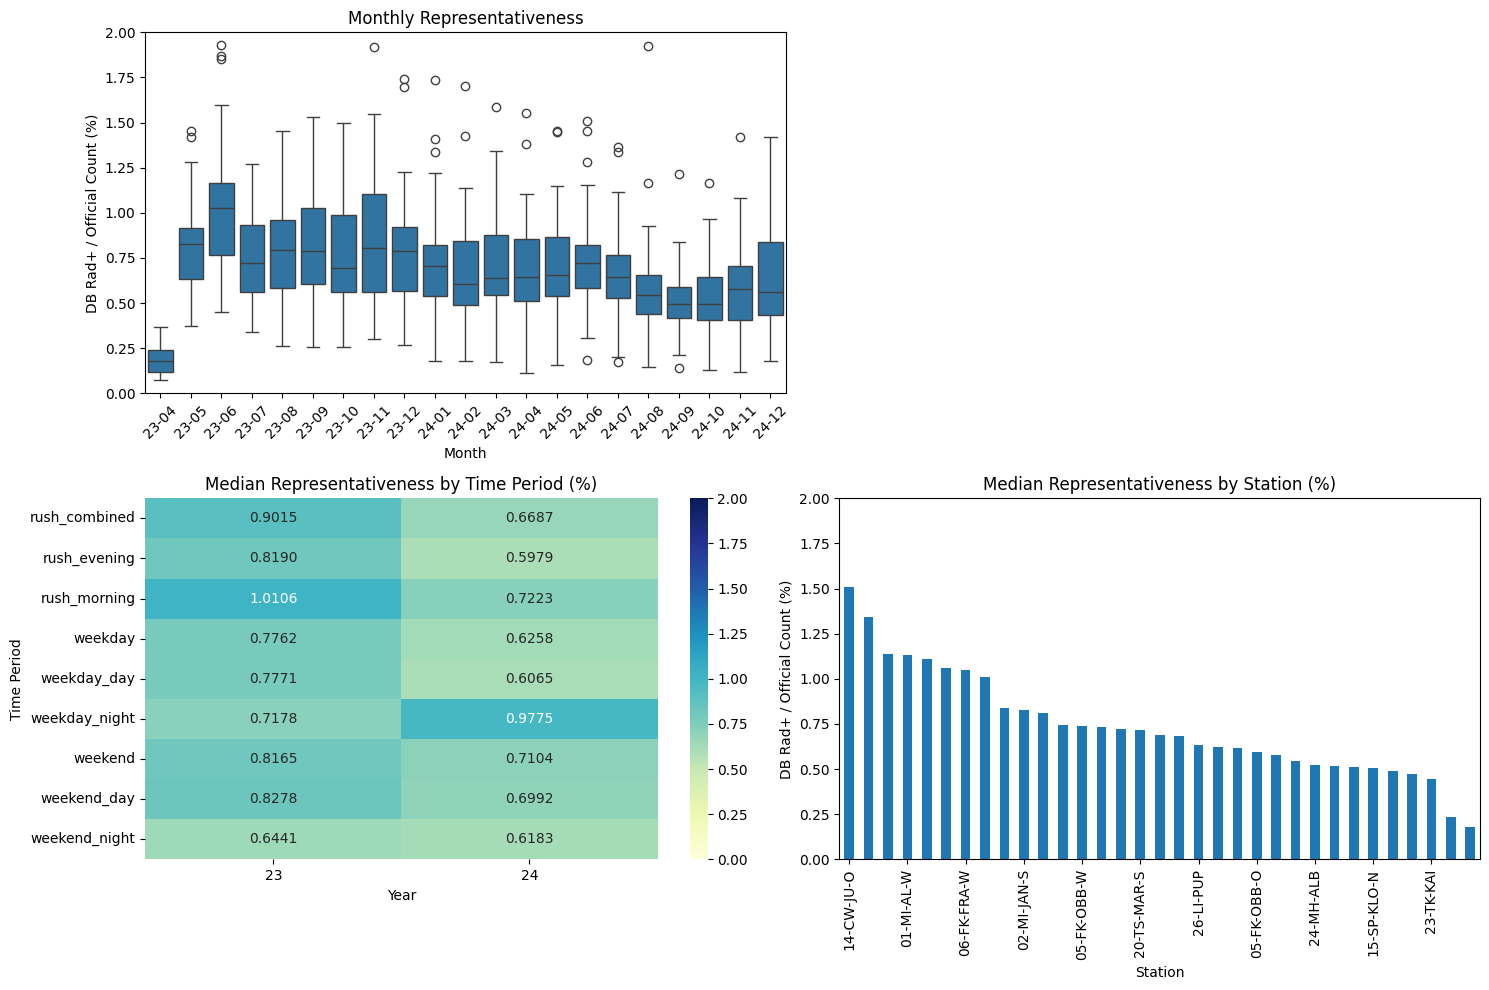

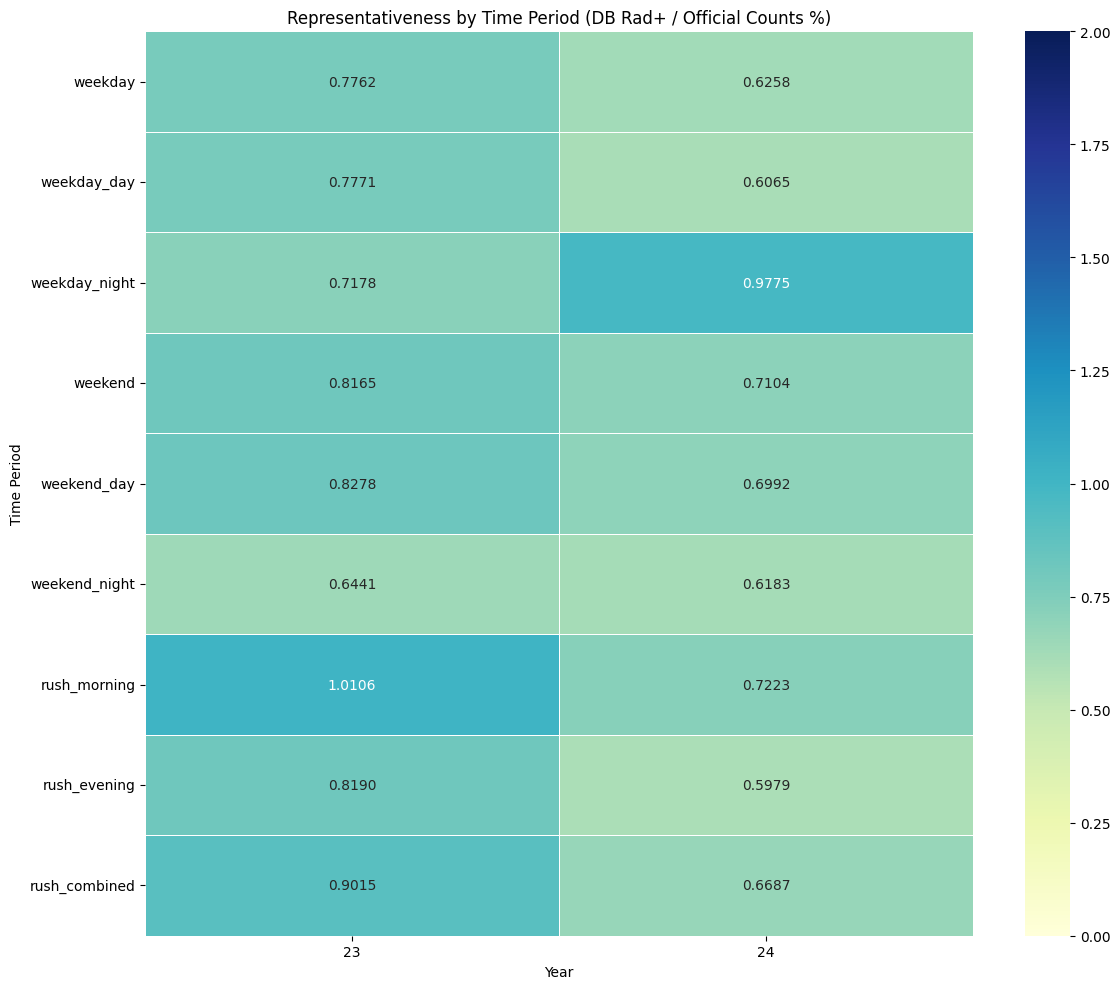

Available period types: ['monthly' 'weekday' 'weekend' 'rush_morning' 'rush_evening'
 'rush_combined' 'weekday_day' 'weekday_night' 'weekend_day'
 'weekend_night']
Number of time period data points: 549
First few time period data rows:
       station   period_type period  db_rad_count  official_count  \
21  01-MI-AL-W       weekday     23        8111.0        682167.0   
22  01-MI-AL-W       weekday     24        9166.0        867249.0   
23  01-MI-AL-W       weekend     23        2032.0        146370.0   
24  01-MI-AL-W       weekend     24        2464.0        192199.0   
25  01-MI-AL-W  rush_morning     23        4241.0        265523.0   

    representativeness  
21            1.189005  
22            1.056905  
23            1.388263  
24            1.282005  
25            1.597225  


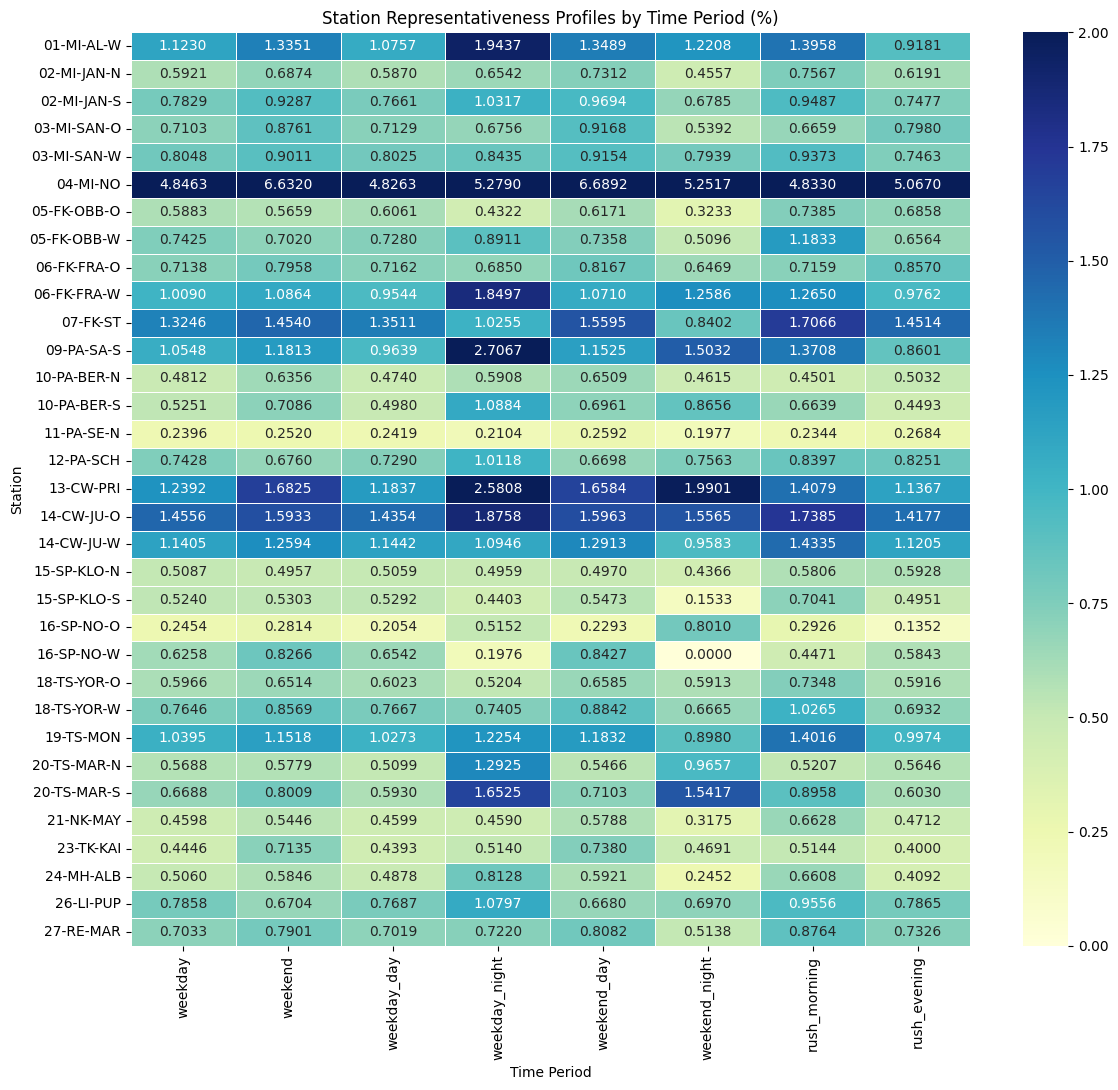

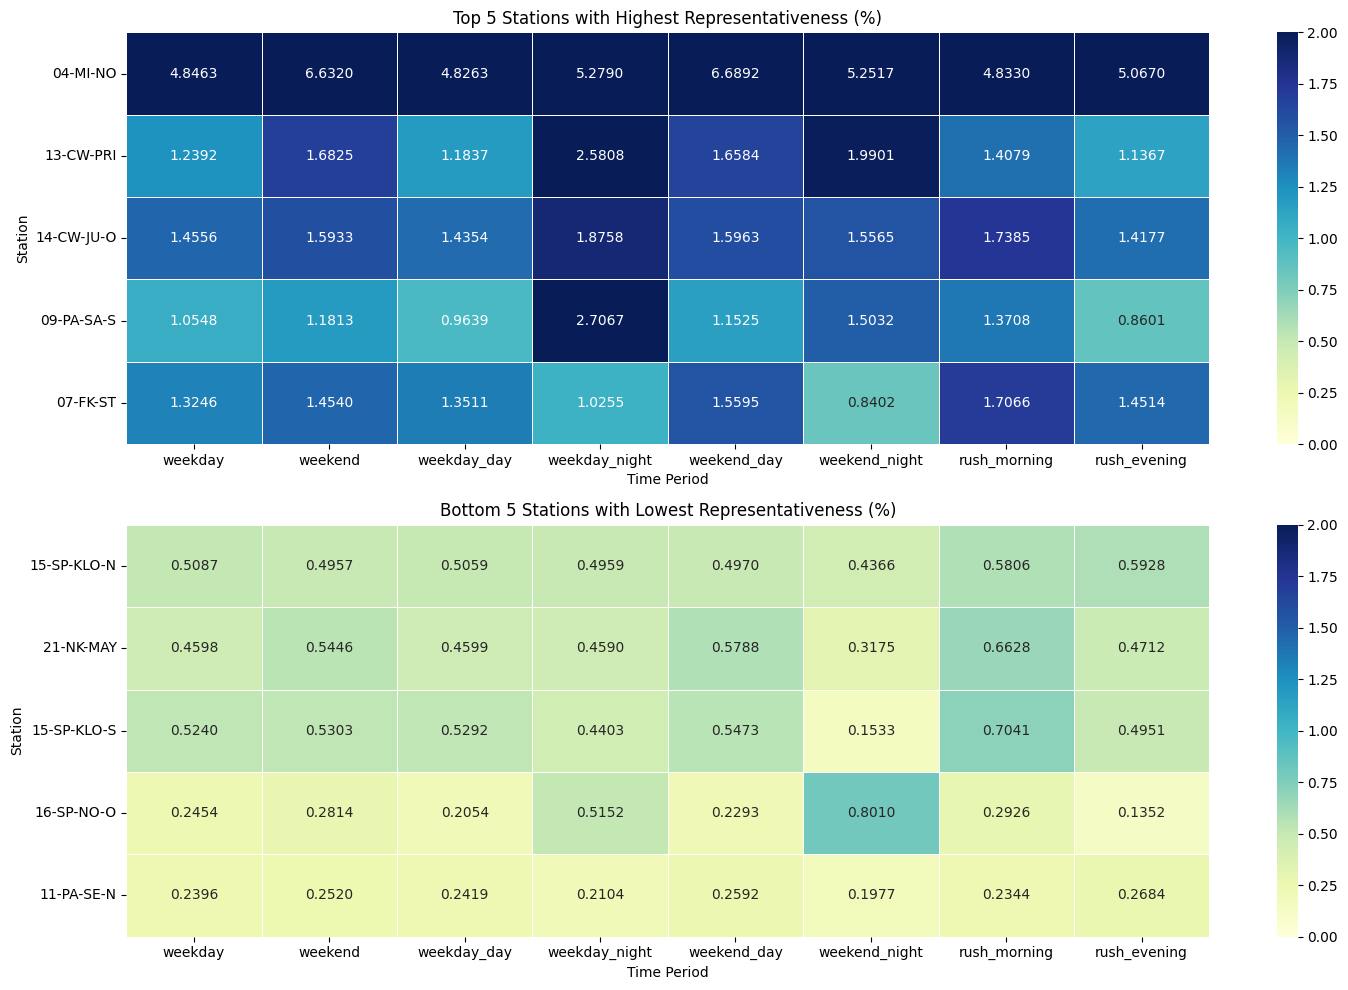

Station profiles exported to analysis_data/FZS-1/station_profiles.csv
Monthly averages exported to analysis_data/FZS-1/monthly_averages.csv


/tmp/ipykernel_550961/340487733.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data['month_num'] = monthly_data['period'].apply(lambda x: int(x.split('-')[1]) if isinstance(x, str) and '-' in x else 0)
/tmp/ipykernel_550961/340487733.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data['year'] = monthly_data['period'].apply(lambda x: '20' + x.split('-')[0] if isinstance(x, str) and '-' in x else '2000')


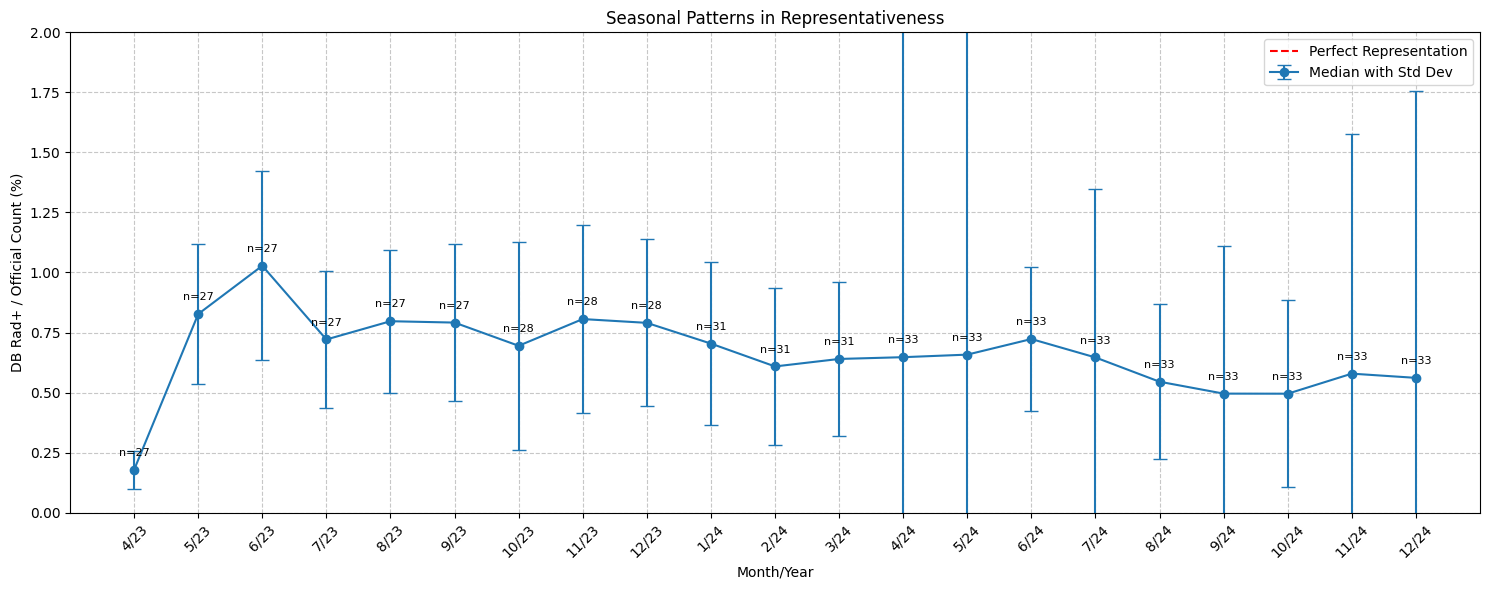

Seasonal patterns by month exported to analysis_data/FZS-1/seasonal_patterns_by_month.csv


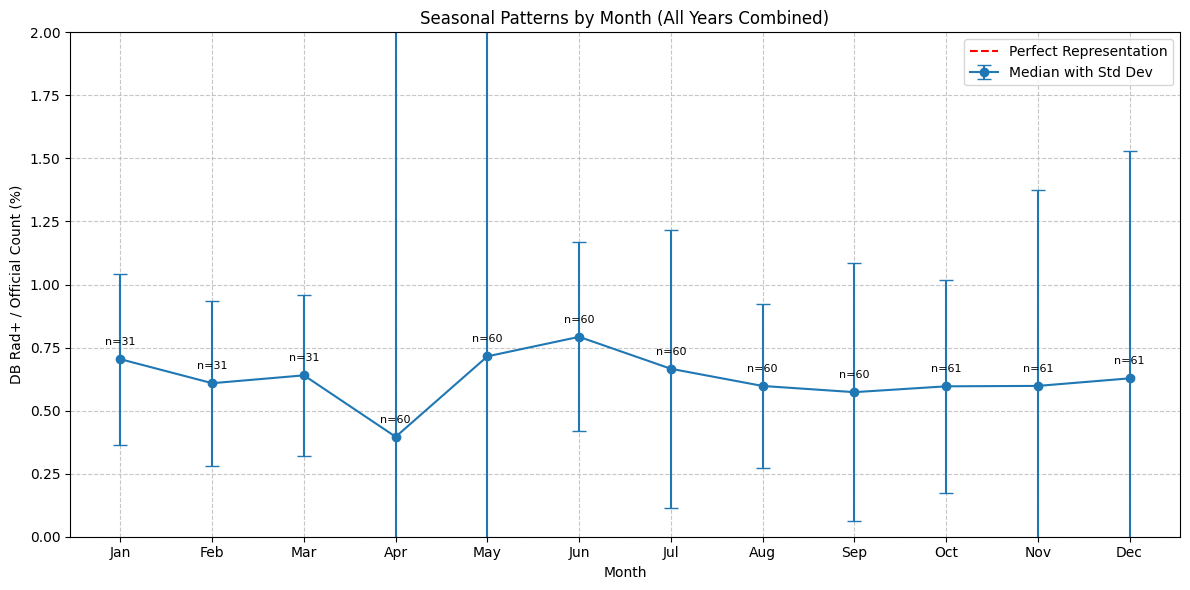

All representativeness data exported to analysis_data/FZS-1/db_rad_representativeness_results.csv
Monthly representativeness data exported to analysis_data/FZS-1/representativeness_monthly.csv
Weekday representativeness data exported to analysis_data/FZS-1/representativeness_weekday.csv
Weekend representativeness data exported to analysis_data/FZS-1/representativeness_weekend.csv
Rush_morning representativeness data exported to analysis_data/FZS-1/representativeness_rush_morning.csv
Rush_evening representativeness data exported to analysis_data/FZS-1/representativeness_rush_evening.csv
Rush_combined representativeness data exported to analysis_data/FZS-1/representativeness_rush_combined.csv
Weekday_day representativeness data exported to analysis_data/FZS-1/representativeness_weekday_day.csv
Weekday_night representativeness data exported to analysis_data/FZS-1/representativeness_weekday_night.csv
Weekend_day representativeness data exported to analysis_data/FZS-1/representativeness_wee

In [23]:
# Schritt 2: parquet-Datei einlesen, Analysieren nach Zählstelle und Zeitraum, Darstellen

# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Define the investigation period
INVESTIGATION_START = pd.Timestamp('2023-04-01')
INVESTIGATION_END = pd.Timestamp('2024-12-31')

# Cell 2: Set output directory and load the data
# Define output directory - change this to your desired location
OUTPUT_DIR = "analysis_data/FZS-1"

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: {OUTPUT_DIR}")
else:
    print(f"Using existing output directory: {OUTPUT_DIR}")

# Define helper function to build output paths
def get_output_path(filename):
    return os.path.join(OUTPUT_DIR, filename)

# Load the datasets
fzs_with_networkdata = pd.read_parquet('data/fzs_with_networkdata.parquet')
fzs_23_24 = pd.read_parquet('data/fzs_23_24.parquet')

# Display basic information about the datasets
print("=== FZS with network data ===")
print(f"Shape: {fzs_with_networkdata.shape}")
print(fzs_with_networkdata.columns.tolist()[:10], "... and more")
print(fzs_with_networkdata.head(2))

print("\n=== FZS 23-24 data ===")
print(f"Shape: {fzs_23_24.shape}")
print(fzs_23_24.columns.tolist()[:10], "... and more")
print(fzs_23_24.head(2))

# Cell 3: Prepare data for analysis
# Convert installation dates to datetime
fzs_with_networkdata['Installationsdatum'] = pd.to_datetime(fzs_with_networkdata['Installationsdatum'])

# Filter data to only include stations within our investigation period
valid_stations = fzs_with_networkdata[fzs_with_networkdata['Installationsdatum'] <= INVESTIGATION_END]
print(f"Number of valid stations: {len(valid_stations)} (out of {len(fzs_with_networkdata)})")

# Cell 4: Calculate station availability during investigation period
def calculate_availability(row):
    """Calculate the percentage of the investigation period the station was active"""
    installation_date = row['Installationsdatum']
    
    # If installed before investigation, it's available for the full period
    if installation_date <= INVESTIGATION_START:
        start_date = INVESTIGATION_START
    else:
        start_date = installation_date
        
    # Calculate total days in investigation period
    total_days = (INVESTIGATION_END - INVESTIGATION_START).days + 1
    
    # Calculate days the station was active during investigation
    active_days = (INVESTIGATION_END - start_date).days + 1
    
    return active_days / total_days

# Add availability percentage to the dataset
valid_stations['availability_pct'] = valid_stations.apply(calculate_availability, axis=1)

# Display availability statistics
print(f"Average station availability: {valid_stations['availability_pct'].mean():.2%}")
print(f"Median station availability: {valid_stations['availability_pct'].median():.2%}")
print(f"Number of stations available for full period: {(valid_stations['availability_pct'] == 1.0).sum()}")

# Cell 5: Prepare time periods for analysis
# Define the time periods from the provided definition
time_periods = {
    'weekday': {'day_of_week': [0, 1, 2, 3, 4], 'suffix': 'weekday'},
    'weekend': {'day_of_week': [5, 6], 'suffix': 'weekend'},
    'rush_morning': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': [6, 7, 8, 9], 'suffix': 'rush_am'},
    'rush_evening': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': [15, 16, 17, 18], 'suffix': 'rush_pm'},
    'rush_combined': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': [6, 7, 8, 9, 15, 16, 17, 18], 'suffix': 'rush_combined'},
    'weekday_day': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': list(range(6, 22)), 'suffix': 'weekday_day'},
    'weekday_night': {'day_of_week': [0, 1, 2, 3, 4], 'hour_of_day': list(range(0, 6)) + list(range(22, 24)), 'suffix': 'weekday_night'},
    'weekend_day': {'day_of_week': [5, 6], 'hour_of_day': list(range(6, 22)), 'suffix': 'weekend_day'},
    'weekend_night': {'day_of_week': [5, 6], 'hour_of_day': list(range(0, 6)) + list(range(22, 24)), 'suffix': 'weekend_night'}
}

# Get all the time period column names from the dataset that match our investigation period
monthly_cols = [col for col in valid_stations.columns if col.startswith(('23-', '24-')) and col.endswith('_route_count')]
yearly_cols = [col for col in valid_stations.columns if col in ['23-all_route_count', '24-all_route_count']]
time_period_cols = [col for col in valid_stations.columns if any(col.endswith(f"{suffix}_route_count") for period in time_periods.values() for suffix in [period['suffix']])]

print("Monthly columns:", monthly_cols[:5], f"... ({len(monthly_cols)} total)")
print("Yearly columns:", yearly_cols)
print("Time period columns:", time_period_cols[:5], f"... ({len(time_period_cols)} total)")

# Cell 6: Calculate representativeness
try:
    # Identify DB Rad+ columns and official count columns
    rad_plus_cols = [col for col in valid_stations.columns if '_route_count' in col]
    official_cols = [col for col in fzs_23_24.columns if col != 'Datum' and col not in ['month', 'year', 'day_of_week', 'hour_of_day']]
    
    print(f"Found {len(rad_plus_cols)} DB Rad+ data columns")
    print(f"Found {len(official_cols)} potential official count columns")
    
    # Show examples of both types of columns
    print("\nDB Rad+ column examples:", rad_plus_cols[:5])
    print("\nOfficial count column examples:", official_cols[:5])
    
    # Get a mapping between station IDs and columns in both datasets
    station_mapping = {}
    
    # Check if 'Zählstelle' is in the valid_stations columns
    if 'Zählstelle' in valid_stations.columns:
        for station_id in valid_stations['Zählstelle']:
            if station_id in fzs_23_24.columns:
                station_mapping[station_id] = station_id
    else:
        print("Warning: 'Zählstelle' column not found in valid_stations dataframe")
        print("Available columns:", valid_stations.columns.tolist())
        
        # Try using the index as station IDs if they match column names
        for station_id in valid_stations.index:
            if isinstance(station_id, str) and station_id in fzs_23_24.columns:
                station_mapping[station_id] = station_id
    
    # Report findings
    print(f"\nFound {len(station_mapping)} stations that exist in both datasets")
    
    if len(station_mapping) == 0:
        print("\nWARNING: No matching stations found between the datasets!")
        print("This will prevent meaningful representativeness calculations.")
        print("\nPossible solutions:")
        print("1. Check column names and data structures")
        print("2. Ensure both datasets use the same station identifier format")
        print("3. Verify that the 'Zählstelle' column exists and contains valid station IDs")
    else:
        print("\nMatching stations (first 5):", list(station_mapping.keys())[:5])
except Exception as e:
    print(f"Error in Cell 6: {e}")
    import traceback
    traceback.print_exc()

# Cell 7: Calculate representativeness for each time period
try:
    # Create a dataframe to store results
    representativeness_results = pd.DataFrame()
    
    # Ensure we have the datetime column properly formatted
    if 'Datum' in fzs_23_24.columns:
        # Group fzs_23_24 by month and time periods according to the definitions
        fzs_23_24['Datum'] = pd.to_datetime(fzs_23_24['Datum'])
        fzs_23_24['month'] = fzs_23_24['Datum'].dt.strftime('%y-%m')
        fzs_23_24['year'] = fzs_23_24['Datum'].dt.strftime('%y')
        fzs_23_24['day_of_week'] = fzs_23_24['Datum'].dt.dayofweek
        fzs_23_24['hour_of_day'] = fzs_23_24['Datum'].dt.hour
        
        print(f"Date range in data: {fzs_23_24['Datum'].min()} to {fzs_23_24['Datum'].max()}")
        print(f"Months in data: {sorted(fzs_23_24['month'].unique())}")
        print(f"Years in data: {sorted(fzs_23_24['year'].unique())}")
    else:
        print("ERROR: 'Datum' column not found in fzs_23_24 dataframe")
        print("Available columns:", fzs_23_24.columns.tolist())
        raise ValueError("Missing required 'Datum' column")
    
    # Function to calculate time period counts from hourly data
    def calculate_period_counts(df, period_def):
        """Calculate counts for a specific time period from hourly data"""
        filtered_df = df.copy()
        
        if 'day_of_week' in period_def:
            filtered_df = filtered_df[filtered_df['day_of_week'].isin(period_def['day_of_week'])]
        
        if 'hour_of_day' in period_def:
            filtered_df = filtered_df[filtered_df['hour_of_day'].isin(period_def['hour_of_day'])]
        
        return filtered_df
    
    # Calculate representativeness for each station and time period
    results = []
    processed_stations = 0
    
    # Ensure we have the Zählstelle column
    if 'Zählstelle' not in valid_stations.columns:
        print("ERROR: 'Zählstelle' column not found in valid_stations dataframe")
        print("Available columns:", valid_stations.columns.tolist())
        raise ValueError("Missing required 'Zählstelle' column")
    
    # Loop through each station
    for station_id, station_row in valid_stations.iterrows():
        station_name = station_row['Zählstelle']
        
        # Skip if station is not in both datasets
        if station_name not in fzs_23_24.columns:
            continue
        
        # Get installation date and calculate availability
        installation_date = station_row['Installationsdatum']
        
        # Filter hourly data for this station and period
        try:
            station_hourly = fzs_23_24[['Datum', 'month', 'year', 'day_of_week', 'hour_of_day', station_name]]
            station_hourly = station_hourly[station_hourly['Datum'] >= installation_date]
            station_hourly = station_hourly[(station_hourly['Datum'] >= INVESTIGATION_START) & 
                                          (station_hourly['Datum'] <= INVESTIGATION_END)]
            
            # Skip if no data available
            if len(station_hourly) == 0:
                print(f"No hourly data available for station {station_name}")
                continue
                
            # Check for NaN values in the station data
            if station_hourly[station_name].isna().all():
                print(f"All values are NaN for station {station_name}")
                continue
                
            if station_hourly[station_name].isna().any():
                print(f"Some values are NaN for station {station_name}")
                # Fill NaN values with 0 to avoid issues in calculations
                station_hourly[station_name] = station_hourly[station_name].fillna(0)
        except Exception as e:
            print(f"Error processing hourly data for station {station_name}: {e}")
            continue
        
        processed_stations += 1
        
        # Monthly representativeness
        for month in sorted(station_hourly['month'].unique()):
            # Skip if this month's column is not in our dataset
            month_col = f"{month}_route_count"
            if month_col not in valid_stations.columns:
                continue
                
            # Get DB Rad+ count for this month
            db_rad_count = station_row.get(month_col, 0)
            
            # Get official count for this month
            month_data = station_hourly[station_hourly['month'] == month]
            official_count = month_data[station_name].sum()
            
            # Calculate representativeness - values should be in PERCENTAGE
            if official_count > 0 and db_rad_count is not None and not pd.isna(db_rad_count):
                # Calculate as percentage - real values are small, around 1%
                representativeness = (db_rad_count / official_count) * 100
                
                # Filter out unreasonable values
                if 0 <= representativeness <= 500:  # Accepting up to 500% to catch outliers
                    results.append({
                        'station': station_name,
                        'period_type': 'monthly',
                        'period': month,
                        'db_rad_count': db_rad_count,
                        'official_count': official_count,
                        'representativeness': representativeness
                    })
        
        # Yearly representativeness
        for year in sorted(station_hourly['year'].unique()):
            # Skip if this year's column is not in our dataset
            year_col = f"{year}-all_route_count"
            if year_col not in valid_stations.columns:
                continue
                
            # Get DB Rad+ count for this year
            db_rad_count = station_row.get(year_col, 0)
            
            # Get official count for this year
            year_data = station_hourly[station_hourly['year'] == year]
            official_count = year_data[station_name].sum()
            
            # Calculate representativeness - values should be in PERCENTAGE
            if official_count > 0 and db_rad_count is not None and not pd.isna(db_rad_count):
                representativeness = (db_rad_count / official_count) * 100
                
                # Filter out unreasonable values
                if 0 <= representativeness <= 500:  # Accepting up to 500% to catch outliers
                    results.append({
                        'station': station_name,
                        'period_type': 'yearly',
                        'period': year,
                        'db_rad_count': db_rad_count,
                        'official_count': official_count,
                        'representativeness': representativeness
                    })
        
        # Time period representativeness
        for period_name, period_def in time_periods.items():
            suffix = period_def['suffix']
            print(f"Processing time period: {period_name} (suffix: {suffix})")
            
            # Check for columns with this suffix for both years
            processed_count = 0
            for year in ['23', '24']:
                # We need to include both monthly and yearly versions of the columns
                possible_prefixes = [f"{year}-", f"{year}-all_"]
                
                for prefix in possible_prefixes:
                    period_col = f"{prefix}{suffix}_route_count"
                    
                    if period_col in valid_stations.columns:
                        print(f"  Found column: {period_col}")
                        
                        # Get DB Rad+ count for this period
                        for station_id, station_row in valid_stations.iterrows():
                            station_name = station_row['Zählstelle']
                            
                            # Skip if station is not in both datasets
                            if station_name not in fzs_23_24.columns:
                                continue
                            
                            db_rad_count = station_row.get(period_col, 0)
                            
                            # Filter hourly data for this time period and year
                            try:
                                year_filter = station_hourly['year'] == year
                                if not any(year_filter):
                                    continue  # Skip if no data for this year
                                    
                                period_data = calculate_period_counts(station_hourly[year_filter], period_def)
                                
                                # Skip if no data
                                if len(period_data) == 0:
                                    continue
                                    
                                # Get official count
                                official_count = period_data[station_name].sum()
                                
                                # Calculate representativeness
                                if official_count > 0 and db_rad_count is not None and not pd.isna(db_rad_count):
                                    representativeness = (db_rad_count / official_count) * 100
                                    
                                    # Filter out unreasonable values
                                    if 0 <= representativeness <= 500:  # Accepting up to 500% to catch outliers
                                        results.append({
                                            'station': station_name,
                                            'period_type': period_name,  # The key fix is using period_name here
                                            'period': f"{year}",
                                            'db_rad_count': db_rad_count,
                                            'official_count': official_count,
                                            'representativeness': representativeness
                                        })
                                        processed_count += 1
                            except Exception as e:
                                print(f"Error processing {period_name} for station {station_name} in year {year}: {e}")
                                continue
            
            print(f"  Processed {processed_count} records for {period_name}")
    
        # Print available columns to check
        print(f"Looking for columns with suffix '{suffix}_route_count'...")
        matching_cols = [col for col in valid_stations.columns if col.endswith(f"{suffix}_route_count")]
        print(f"Found {len(matching_cols)} matching columns: {matching_cols}")                
    
    print(f"Processed {processed_stations} stations with data")
    print(f"Collected {len(results)} representativeness data points")
    
    # Convert results to DataFrame
    representativeness_df = pd.DataFrame(results)
    
    # Print basic statistics about the results
    if not representativeness_df.empty:
        print("\nRepresentativeness statistics (%):")
        print(f"Mean: {representativeness_df['representativeness'].mean():.4f}%")
        print(f"Median: {representativeness_df['representativeness'].median():.4f}%")
        print(f"Min: {representativeness_df['representativeness'].min():.4f}%")
        print(f"Max: {representativeness_df['representativeness'].max():.4f}%")
        
        # Count by period type
        print("\nData points by period type:")
        print(representativeness_df['period_type'].value_counts())
    else:
        print("WARNING: No representativeness data was calculated!")
        
except Exception as e:
    print(f"Error in representativeness calculation: {e}")
    import traceback
    traceback.print_exc()
    
    # Create an empty DataFrame if we encounter an error
    representativeness_df = pd.DataFrame(columns=['station', 'period_type', 'period', 
                                                'db_rad_count', 'official_count', 'representativeness'])

# Cell 8: Analyze the representativeness
# Display summary statistics
print("=== Representativeness Summary (DB Rad+ / Official Counts) ===")
if not representativeness_df.empty:
    summary = representativeness_df.groupby(['period_type', 'period'])['representativeness'].agg(['mean', 'median', 'std', 'count'])
    print(summary)
else:
    print("No representativeness data available for summary")

# Cell 9: Visualize the results
if not representativeness_df.empty:
    # Set a fixed max value of 2% for all plots as specified
    max_plot_value = 2.0
    
    # Create plots for different types of time periods
    plt.figure(figsize=(15, 10))
    has_subplot = False  # Track if we created any subplots

    # Monthly representativeness
    monthly_data = representativeness_df[representativeness_df['period_type'] == 'monthly']
    if not monthly_data.empty:
        plt.subplot(2, 2, 1)
        sns.boxplot(x='period', y='representativeness', data=monthly_data)
        plt.title('Monthly Representativeness')
        plt.xlabel('Month')
        plt.ylabel('DB Rad+ / Official Count (%)')
        plt.xticks(rotation=45)
        plt.axhline(y=100.0, color='r', linestyle='--')
        
        # Scale to fixed 2% as specified
        plt.ylim(0, max_plot_value)
        
        has_subplot = True

    # Yearly representativeness
    yearly_data = representativeness_df[representativeness_df['period_type'] == 'yearly']
    if not yearly_data.empty:
        plt.subplot(2, 2, 2)
        sns.boxplot(x='period', y='representativeness', data=yearly_data)
        plt.title('Yearly Representativeness')
        plt.xlabel('Year')
        plt.ylabel('DB Rad+ / Official Count (%)')
        plt.axhline(y=100.0, color='r', linestyle='--')
        
        # Scale to fixed 2% as specified
        plt.ylim(0, max_plot_value)
            
        has_subplot = True

    # Time period representativeness
    period_data = representativeness_df[~representativeness_df['period_type'].isin(['monthly', 'yearly'])]
    if not period_data.empty:
        try:
            pivot_data = period_data.pivot_table(
                index='period_type', 
                columns='period', 
                values='representativeness',
                aggfunc='median'
            )
            
            # Check if pivot table has data
            if not pivot_data.empty and pivot_data.size > 0:
                plt.subplot(2, 2, 3)
                sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.4f', 
                            vmin=0, vmax=max_plot_value)  # Scale to fixed 2%
                plt.title('Median Representativeness by Time Period (%)')
                plt.xlabel('Year')
                plt.ylabel('Time Period')
                has_subplot = True
            else:
                print("No data available for time period heatmap")
        except Exception as e:
            print(f"Error creating time period pivot table: {e}")

    # Station-level representativeness
    try:
        station_rep = representativeness_df.groupby('station')['representativeness'].median().sort_values(ascending=False)
        if not station_rep.empty:
            plt.subplot(2, 2, 4)
            station_rep.plot(kind='bar')
            plt.title('Median Representativeness by Station (%)')
            plt.xlabel('Station')
            plt.ylabel('DB Rad+ / Official Count (%)')
            plt.axhline(y=100.0, color='r', linestyle='--')
            plt.xticks(rotation=90)
            if len(station_rep) > 10:
                plt.xticks(range(0, len(station_rep), max(1, len(station_rep) // 10)))
                
            # Scale to fixed 2% as specified
            plt.ylim(0, max_plot_value)
            has_subplot = True
    except Exception as e:
        print(f"Error creating station representativeness plot: {e}")

    # Only save and show if we have at least one subplot
    if has_subplot:
        plt.tight_layout()
        plt.savefig(get_output_path('db_rad_representativeness.png'), dpi=300)
        plt.show()
    else:
        plt.close()
        print("No visualizations created - insufficient data")
else:
    print("No representativeness data available for visualization")

# Cell 10: Create a more detailed heatmap for time periods
# First check if we have time period data
period_data = representativeness_df[~representativeness_df['period_type'].isin(['monthly', 'yearly'])]

if len(period_data) > 0:
    try:
        # Create a heatmap for all time periods
        period_pivot = period_data.pivot_table(
            index='period_type',
            columns=['period'],
            values='representativeness',
            aggfunc='median'
        )

        # Check if we have data to plot
        if not period_pivot.empty and period_pivot.size > 0:
            plt.figure(figsize=(12, 10))
            
            # Sort rows by period type to group related periods
            period_order = [
                'weekday', 'weekday_day', 'weekday_night',
                'weekend', 'weekend_day', 'weekend_night',
                'rush_morning', 'rush_evening', 'rush_combined'
            ]
            period_pivot = period_pivot.reindex(
                [p for p in period_order if p in period_pivot.index]
            )
            
            # Make sure we still have data after reindexing
            if not period_pivot.empty and period_pivot.size > 0:
                # Fixed scale to 2% as specified
                max_plot_value = 2.0
                
                sns.heatmap(period_pivot, annot=True, cmap='YlGnBu', fmt='.4f', 
                            linewidths=0.5, vmin=0, vmax=max_plot_value)
                plt.title('Representativeness by Time Period (DB Rad+ / Official Counts %)')
                plt.xlabel('Year')
                plt.ylabel('Time Period')
                plt.tight_layout()
                plt.savefig(get_output_path('time_period_representativeness.png'), dpi=300)
                plt.show()
            else:
                print("No data available for time period heatmap after reindexing")
        else:
            print("No data available for time period heatmap")
    except Exception as e:
        print(f"Error creating time period heatmap: {e}")
else:
    print("No time period data available for heatmap")

# Cell 11: Analyze station-specific trends
# Calculate average representativeness by time of day

# Add this at the beginning of Cell 11 (station profiles) to debug
print("Available period types:", representativeness_df['period_type'].unique())
time_period_data = representativeness_df[~representativeness_df['period_type'].isin(['monthly', 'yearly'])]
print(f"Number of time period data points: {len(time_period_data)}")
print(f"First few time period data rows:")
print(time_period_data.head())

if not representativeness_df.empty:
    try:
        # Create station profiles
        station_profiles = {}
        
        for station in representativeness_df['station'].unique():
            station_data = representativeness_df[representativeness_df['station'] == station]
            
            # Get representativeness for different time periods
            profile = {}
            for period_type in ['weekday', 'weekend', 'weekday_day', 'weekday_night', 
                                'weekend_day', 'weekend_night', 'rush_morning', 'rush_evening']:
                period_values = station_data[station_data['period_type'] == period_type]['representativeness']
                if not period_values.empty:
                    profile[period_type] = period_values.median()
            
            if profile:
                station_profiles[station] = profile
        
        # Convert to DataFrame for easier analysis
        if station_profiles:  # Check if we have any profiles
            profiles_df = pd.DataFrame.from_dict(station_profiles, orient='index')
            
            # Check if we have data to plot
            if not profiles_df.empty and profiles_df.size > 0:
                # Fixed scale to 2% as specified
                max_plot_value = 2.0
                
                # Create a heatmap of station profiles
                plt.figure(figsize=(12, max(8, len(station_profiles) / 3)))
                sns.heatmap(profiles_df, annot=True, cmap='YlGnBu', fmt='.4f', 
                            linewidths=0.5, vmin=0, vmax=max_plot_value)
                plt.title('Station Representativeness Profiles by Time Period (%)')
                plt.xlabel('Time Period')
                plt.ylabel('Station')
                plt.tight_layout()
                plt.savefig(get_output_path('station_profiles.png'), dpi=300)
                plt.show()
                
                # Also create a profile comparison for top and bottom stations
                if len(profiles_df) > 5:
                    # Calculate average representativeness for each station
                    avg_rep = profiles_df.mean(axis=1).sort_values(ascending=False)
                    top5 = avg_rep.head(5).index
                    bottom5 = avg_rep.tail(5).index
                    
                    # Plot comparison
                    plt.figure(figsize=(15, 10))
                    
                    plt.subplot(2, 1, 1)
                    top5_df = profiles_df.loc[top5]
                    sns.heatmap(top5_df, annot=True, cmap='YlGnBu', fmt='.4f', 
                                linewidths=0.5, vmin=0, vmax=max_plot_value)
                    plt.title('Top 5 Stations with Highest Representativeness (%)')
                    plt.xlabel('Time Period')
                    plt.ylabel('Station')
                    
                    plt.subplot(2, 1, 2)
                    bottom5_df = profiles_df.loc[bottom5]
                    sns.heatmap(bottom5_df, annot=True, cmap='YlGnBu', fmt='.4f', 
                                linewidths=0.5, vmin=0, vmax=max_plot_value)
                    plt.title('Bottom 5 Stations with Lowest Representativeness (%)')
                    plt.xlabel('Time Period')
                    plt.ylabel('Station')
                    
                    plt.tight_layout()
                    plt.savefig(get_output_path('station_profile_comparison.png'), dpi=300)
                    plt.show()
                    
                # Save the profiles data to CSV
                profiles_df.to_csv(get_output_path('station_profiles.csv'))
                print(f"Station profiles exported to {get_output_path('station_profiles.csv')}")
            else:
                print("No data available for station profiles heatmap")
        else:
            print("No station profiles data available")
    except Exception as e:
        print(f"Error creating station profiles: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No representativeness data available for station profiles")

# Cell 12: Analyze seasonal patterns (if monthly data is available)
if 'monthly_data' in locals() and not monthly_data.empty:
    try:
        # Extract month number for sorting
        monthly_data['month_num'] = monthly_data['period'].apply(lambda x: int(x.split('-')[1]) if isinstance(x, str) and '-' in x else 0)
        monthly_data['year'] = monthly_data['period'].apply(lambda x: '20' + x.split('-')[0] if isinstance(x, str) and '-' in x else '2000')
        
        # Filter out any rows with parsing errors
        monthly_data = monthly_data[(monthly_data['month_num'] > 0) & (monthly_data['year'] >= '2020')]
        
        if not monthly_data.empty:
            # Calculate average representativeness by month
            monthly_avg = monthly_data.groupby(['year', 'month_num'])['representativeness'].agg(['median', 'mean', 'std', 'count'])
            monthly_avg = monthly_avg.reset_index()
            
            if not monthly_avg.empty:
                monthly_avg['month_year'] = monthly_avg.apply(lambda x: f"{x['month_num']}/{x['year'][-2:]}", axis=1)
                monthly_avg['sort_key'] = monthly_avg.apply(lambda x: int(x['year']) * 100 + x['month_num'], axis=1)
                monthly_avg = monthly_avg.sort_values('sort_key')
                
                # Export monthly averages to CSV
                monthly_avg.to_csv(get_output_path('monthly_averages.csv'), index=False)
                print(f"Monthly averages exported to {get_output_path('monthly_averages.csv')}")
                
                if len(monthly_avg) > 0:
                    # Fixed scale to 2% as specified
                    max_plot_value = 2.0
                    
                    # Plot seasonal patterns
                    plt.figure(figsize=(15, 6))
                    
                    # Line plot with error bars
                    plt.errorbar(
                        range(len(monthly_avg)), 
                        monthly_avg['median'], 
                        yerr=monthly_avg['std'], 
                        fmt='o-', 
                        capsize=5,
                        label='Median with Std Dev'
                    )
                    
                    # Add reference line for 100%
                    plt.axhline(y=100.0, color='r', linestyle='--', label='Perfect Representation')
                    
                    # Set labels and title
                    plt.xticks(range(len(monthly_avg)), monthly_avg['month_year'], rotation=45)
                    plt.xlabel('Month/Year')
                    plt.ylabel('DB Rad+ / Official Count (%)')
                    plt.title('Seasonal Patterns in Representativeness')
                    plt.grid(True, linestyle='--', alpha=0.7)
                    plt.legend()
                    
                    # Set y-axis to fixed 2% scale as specified
                    plt.ylim(0, max_plot_value)
                    
                    # Annotate with count of stations
                    for i, (_, row) in enumerate(monthly_avg.iterrows()):
                        plt.annotate(
                            f"n={int(row['count'])}",
                            (i, row['median']),
                            textcoords="offset points",
                            xytext=(0, 10),
                            ha='center',
                            fontsize=8
                        )
                    
                    plt.tight_layout()
                    plt.savefig(get_output_path('seasonal_patterns.png'), dpi=300)
                    plt.show()
                    
                    # Also plot by month number to see seasonal patterns
                    month_seasonal = monthly_data.groupby('month_num')['representativeness'].agg(['median', 'mean', 'std', 'count'])
                    month_seasonal = month_seasonal.reset_index()
                    
                    # Export seasonal patterns by month to CSV
                    month_seasonal.to_csv(get_output_path('seasonal_patterns_by_month.csv'), index=False)
                    print(f"Seasonal patterns by month exported to {get_output_path('seasonal_patterns_by_month.csv')}")
                    
                    plt.figure(figsize=(12, 6))
                    plt.errorbar(
                        month_seasonal['month_num'],
                        month_seasonal['median'],
                        yerr=month_seasonal['std'],
                        fmt='o-',
                        capsize=5,
                        label='Median with Std Dev'
                    )
                    
                    # Add reference line for 100%
                    plt.axhline(y=100.0, color='r', linestyle='--', label='Perfect Representation')
                    
                    # Set labels and title
                    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
                    plt.xlabel('Month')
                    plt.ylabel('DB Rad+ / Official Count (%)')
                    plt.title('Seasonal Patterns by Month (All Years Combined)')
                    plt.grid(True, linestyle='--', alpha=0.7)
                    plt.legend()
                    
                    # Set y-axis to fixed 2% scale as specified
                    plt.ylim(0, max_plot_value)
                    
                    # Annotate with count of stations
                    for i, (_, row) in enumerate(month_seasonal.iterrows()):
                        plt.annotate(
                            f"n={int(row['count'])}",
                            (row['month_num'], row['median']),
                            textcoords="offset points",
                            xytext=(0, 10),
                            ha='center',
                            fontsize=8
                        )
                    
                    plt.tight_layout()
                    plt.savefig(get_output_path('seasonal_patterns_by_month.png'), dpi=300)
                    plt.show()
                else:
                    print("No data available for seasonal patterns plot after processing")
            else:
                print("No aggregated monthly data available for seasonal patterns")
        else:
            print("No valid monthly data after parsing month/year")
    except Exception as e:
        print(f"Error processing monthly data: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No monthly data available for seasonal patterns analysis")
# Cell 13: Export results to CSV for further analysis
# Export all representativeness data
representativeness_df.to_csv(get_output_path('db_rad_representativeness_results.csv'), index=False)
print(f"All representativeness data exported to {get_output_path('db_rad_representativeness_results.csv')}")

# Export data by period type
for period_type in representativeness_df['period_type'].unique():
    type_data = representativeness_df[representativeness_df['period_type'] == period_type]
    if not type_data.empty:
        filename = f"representativeness_{period_type}.csv"
        type_data.to_csv(get_output_path(filename), index=False)
        print(f"{period_type.capitalize()} representativeness data exported to {get_output_path(filename)}")

# Export summary statistics
summary = representativeness_df.groupby(['period_type', 'period'])['representativeness'].agg(['mean', 'median', 'std', 'count']).reset_index()
summary.to_csv(get_output_path('representativeness_summary.csv'), index=False)
print(f"Summary statistics exported to {get_output_path('representativeness_summary.csv')}")

# Export station statistics
station_stats = representativeness_df.groupby('station')['representativeness'].agg(['mean', 'median', 'std', 'count']).reset_index()
station_stats.to_csv(get_output_path('station_statistics.csv'), index=False)
print(f"Station statistics exported to {get_output_path('station_statistics.csv')}")

# Cell 14: Summary and recommendations
print("=== Summary of DB Rad+ Representativeness Analysis ===")
print(f"Analysis period: {INVESTIGATION_START.strftime('%Y-%m-%d')} to {INVESTIGATION_END.strftime('%Y-%m-%d')}")

if representativeness_df.empty:
    print("No representativeness data was calculated. Please check previous error messages.")
else:
    # Save summary to text file
    with open(get_output_path('analysis_summary.txt'), 'w') as f:
        f.write(f"=== Summary of DB Rad+ Representativeness Analysis ===\n")
        f.write(f"Analysis period: {INVESTIGATION_START.strftime('%Y-%m-%d')} to {INVESTIGATION_END.strftime('%Y-%m-%d')}\n\n")
        
        # Count stations analyzed
        stations = representativeness_df['station'].unique()
        f.write(f"Total stations analyzed: {len(stations)}\n\n")
        
        # Overall representativeness
        overall_rep = representativeness_df['representativeness'].median()
        f.write(f"Overall median representativeness: {overall_rep:.4f}%\n\n")
        
        # Time period with highest and lowest representativeness
        if 'period_type' in representativeness_df.columns:
            period_rep = representativeness_df.groupby('period_type')['representativeness'].median().sort_values()
            if len(period_rep) > 0:
                f.write(f"Lowest representativeness: {period_rep.index[0]} ({period_rep.iloc[0]:.4f}%)\n")
                f.write(f"Highest representativeness: {period_rep.index[-1]} ({period_rep.iloc[-1]:.4f}%)\n\n")
        
        # Monthly trends
        if 'monthly_data' in locals() and not monthly_data.empty:
            monthly_trend = monthly_data.groupby('period')['representativeness'].median().sort_values()
            if len(monthly_trend) > 0:
                f.write(f"Month with lowest representativeness: {monthly_trend.index[0]} ({monthly_trend.iloc[0]:.4f}%)\n")
                f.write(f"Month with highest representativeness: {monthly_trend.index[-1]} ({monthly_trend.iloc[-1]:.4f}%)\n\n")
        
        # Station variation
        try:
            station_variation = representativeness_df.groupby('station')['representativeness'].agg(['median', 'std'])
            if 'std' in station_variation.columns and not station_variation['std'].isna().all():
                median_std = station_variation['std'].median()
                high_variation_stations = station_variation[station_variation['std'] > median_std]
                f.write(f"Stations with high variability in representativeness: {len(high_variation_stations)}\n\n")
                
                # Top 5 stations with highest and lowest representativeness
                top_stations = station_variation.sort_values('median', ascending=False).head(5)
                bottom_stations = station_variation.sort_values('median').head(5)
                
                f.write("Top 5 stations with highest representativeness:\n")
                for station, row in top_stations.iterrows():
                    f.write(f"  {station}: {row['median']:.4f}% (std: {row['std']:.4f}%)\n")
                
                f.write("\nBottom 5 stations with lowest representativeness:\n")
                for station, row in bottom_stations.iterrows():
                    f.write(f"  {station}: {row['median']:.4f}% (std: {row['std']:.4f}%)\n")
                f.write("\n")
        except Exception as e:
            f.write(f"Error calculating station variation: {e}\n\n")
        
        # Additional insights
        f.write("Additional Insights:\n")
        
        # Seasonal patterns
        if 'monthly_data' in locals() and not monthly_data.empty:
            if 'month_num' in monthly_data.columns:
                try:
                    # Group by month number to see seasonal patterns
                    monthly_seasonal = monthly_data.groupby('month_num')['representativeness'].median()
                    if len(monthly_seasonal) > 0:
                        highest_month = monthly_seasonal.idxmax()
                        lowest_month = monthly_seasonal.idxmin()
                        f.write(f"Seasonal pattern: Highest in month {highest_month} ({monthly_seasonal.max():.4f}%), lowest in month {lowest_month} ({monthly_seasonal.min():.4f}%)\n")
                except Exception as e:
                    f.write(f"Error analyzing seasonal patterns: {e}\n")
        
        # Weekday vs weekend comparison
        if 'period_type' in representativeness_df.columns:
            try:
                weekday_rep = representativeness_df[representativeness_df['period_type'] == 'weekday']['representativeness'].median()
                weekend_rep = representativeness_df[representativeness_df['period_type'] == 'weekend']['representativeness'].median()
                
                if not pd.isna(weekday_rep) and not pd.isna(weekend_rep):
                    f.write(f"Weekday vs Weekend: Weekday ({weekday_rep:.4f}%) vs Weekend ({weekend_rep:.4f}%)\n")
                    if weekday_rep > weekend_rep:
                        f.write(f"  DB Rad+ data is more representative for weekdays than weekends by {(weekday_rep - weekend_rep):.4f} percentage points\n")
                    else:
                        f.write(f"  DB Rad+ data is more representative for weekends than weekdays by {(weekend_rep - weekday_rep):.4f} percentage points\n")
            except Exception as e:
                f.write(f"Error comparing weekday vs weekend: {e}\n")
        
        # Rush hour comparison
        if 'period_type' in representativeness_df.columns:
            try:
                rush_am = representativeness_df[representativeness_df['period_type'] == 'rush_morning']['representativeness'].median()
                rush_pm = representativeness_df[representativeness_df['period_type'] == 'rush_evening']['representativeness'].median()
                
                if not pd.isna(rush_am) and not pd.isna(rush_pm):
                    f.write(f"Rush hour comparison: Morning ({rush_am:.4f}%) vs Evening ({rush_pm:.4f}%)\n")
                    if rush_am > rush_pm:
                        f.write(f"  DB Rad+ data is more representative for morning rush hours by {(rush_am - rush_pm):.4f} percentage points\n")
                    else:
                        f.write(f"  DB Rad+ data is more representative for evening rush hours by {(rush_pm - rush_am):.4f} percentage points\n")
            except Exception as e:
                f.write(f"Error comparing rush hours: {e}\n")
                
        # Year-over-year change
        if 'period' in representativeness_df.columns:
            try:
                y2023 = representativeness_df[representativeness_df['period'] == '23']['representativeness'].median()
                y2024 = representativeness_df[representativeness_df['period'] == '24']['representativeness'].median()
                
                if not pd.isna(y2023) and not pd.isna(y2024):
                    change = (y2024 - y2023)
                    f.write(f"Year-over-year change: 2023 ({y2023:.4f}%) to 2024 ({y2024:.4f}%): {change:+.4f} percentage points\n")
            except Exception as e:
                f.write(f"Error calculating year-over-year change: {e}\n")
                
        f.write("\nRecommendations:\n")
        f.write("1. When using DB Rad+ data, consider applying correction factors based on the representativeness values\n")
        f.write("2. Be especially cautious when analyzing time periods with lower representativeness\n")
        f.write("3. Consider station-specific adjustments for locations with unusual patterns\n")
        
        # Determine if the representativeness is consistently very low
        overall_max = representativeness_df['representativeness'].quantile(0.95)
        if overall_max < 3:
            f.write("\nNOTE: The DB Rad+ data represents a very small percentage (less than 3%) of the official count.\n")
            f.write("This suggests DB Rad+ captures only a fraction of the total bicycle traffic.\n")
            f.write("Any analysis using DB Rad+ data should take this low representation into account.\n")
    
    print(f"Analysis summary saved to {get_output_path('analysis_summary.txt')}")
    
    # Print summary to console
    print(f"Total stations analyzed: {len(representativeness_df['station'].unique())}")
    
    # Overall representativeness
    overall_rep = representativeness_df['representativeness'].median()
    print(f"Overall median representativeness: {overall_rep:.4f}%")
    
    # Time period with highest and lowest representativeness
    if 'period_type' in representativeness_df.columns:
        period_rep = representativeness_df.groupby('period_type')['representativeness'].median().sort_values()
        if len(period_rep) > 0:
            print(f"Lowest representativeness: {period_rep.index[0]} ({period_rep.iloc[0]:.4f}%)")
            print(f"Highest representativeness: {period_rep.index[-1]} ({period_rep.iloc[-1]:.4f}%)")
    
    # Monthly trends
    if 'monthly_data' in locals() and not monthly_data.empty:
        monthly_trend = monthly_data.groupby('period')['representativeness'].median().sort_values()
        if len(monthly_trend) > 0:
            print(f"Month with lowest representativeness: {monthly_trend.index[0]} ({monthly_trend.iloc[0]:.4f}%)")
            print(f"Month with highest representativeness: {monthly_trend.index[-1]} ({monthly_trend.iloc[-1]:.4f}%)")
    
    # Station variation
    try:
        station_variation = representativeness_df.groupby('station')['representativeness'].agg(['median', 'std'])
        if 'std' in station_variation.columns and not station_variation['std'].isna().all():
            median_std = station_variation['std'].median()
            high_variation_stations = station_variation[station_variation['std'] > median_std]
            print(f"Stations with high variability in representativeness: {len(high_variation_stations)}")
            
            # Print top 5 stations with highest and lowest representativeness
            top_stations = station_variation.sort_values('median', ascending=False).head(5)
            bottom_stations = station_variation.sort_values('median').head(5)
            
            print("\nTop 5 stations with highest representativeness:")
            for station, row in top_stations.iterrows():
                print(f"  {station}: {row['median']:.4f}% (std: {row['std']:.4f}%)")
                
            print("\nBottom 5 stations with lowest representativeness:")
            for station, row in bottom_stations.iterrows():
                print(f"  {station}: {row['median']:.4f}% (std: {row['std']:.4f}%)")
    except Exception as e:
        print(f"Error calculating station variation: {e}")

In [24]:
# Schritt 3: CSV Datei erstellen für Analysen und Darstellung in QGIS

# Cell to create a master CSV file for QGIS mapping
import pandas as pd
import os
import glob

print("Creating master CSV file for QGIS mapping...")

# Get all CSV files from the output directory
csv_files = glob.glob(os.path.join(OUTPUT_DIR, "*.csv"))
print(f"Found {len(csv_files)} CSV files in {OUTPUT_DIR}")

# Initialize dataframes to store different types of data
all_data = pd.DataFrame()
station_stats = pd.DataFrame()

# Process each CSV file
for file in csv_files:
    filename = os.path.basename(file)
    print(f"Processing {filename}...")
    
    df = pd.read_csv(file)
    
    # Categorize the file based on its name and content
    if "station_statistics" in filename and "station" in df.columns:
        # Station statistics file has overall metrics
        station_stats = df
    elif "representativeness_results" in filename or "representativeness_" in filename:
        # General representativeness data
        if all_data.empty:
            all_data = df
        else:
            # Make sure we're not adding duplicates
            if "period_type" in df.columns and "station" in df.columns:
                all_data = pd.concat([all_data, df], ignore_index=True).drop_duplicates()

# If we have both types of data, process them
if not all_data.empty:
    # Get unique stations
    stations = all_data["station"].unique()
    print(f"Found {len(stations)} unique stations")
    
    # Create a master dataframe for QGIS mapping
    master_df = pd.DataFrame({"station_id": stations})
    
    # Add station statistics if available
    if not station_stats.empty:
        station_stats_pivoted = station_stats.set_index("station")
        for col in station_stats_pivoted.columns:
            master_df[f"stats_{col}"] = master_df["station_id"].map(station_stats_pivoted[col])
    
    # Add data for each period type
    period_types = all_data["period_type"].unique()
    print(f"Found {len(period_types)} period types: {period_types}")
    
    for period_type in period_types:
        period_data = all_data[all_data["period_type"] == period_type]
        
        # Group by station and period
        for period in period_data["period"].unique():
            # Get data for this period
            period_subset = period_data[(period_data["period"] == period)]
            
            # Create a pivot table
            if not period_subset.empty:
                # Create a pivot with station as index and representativeness as value
                pivot = period_subset.pivot_table(
                    index="station", 
                    values="representativeness", 
                    aggfunc="median"
                )
                
                # Add to master dataframe
                column_name = f"{period_type}_{period}"
                master_df[column_name] = master_df["station_id"].map(pivot["representativeness"])
    
    # Export the master CSV
    master_file = os.path.join(OUTPUT_DIR, "master_representativeness_for_qgis.csv")
    master_df.to_csv(master_file, index=False)
    print(f"Master CSV file created at {master_file} with {len(master_df)} rows and {len(master_df.columns)} columns")
    
    # Print sample of the data
    print("\nSample of the master CSV file:")
    print(master_df.head())
    
    # Print column names for reference
    print("\nAvailable columns in the master CSV file:")
    for col in master_df.columns:
        print(f"  {col}")
else:
    print("No representativeness data found to create master CSV file")

Creating master CSV file for QGIS mapping...
Found 16 CSV files in analysis_data/FZS-1
Processing representativeness_weekend.csv...
Processing representativeness_weekday.csv...
Processing representativeness_weekday_day.csv...
Processing representativeness_weekend_day.csv...
Processing seasonal_patterns_by_month.csv...
Processing station_statistics.csv...
Processing monthly_averages.csv...
Processing station_profiles.csv...
Processing representativeness_rush_combined.csv...
Processing representativeness_monthly.csv...
Processing representativeness_rush_morning.csv...
Processing db_rad_representativeness_results.csv...
Processing representativeness_weekday_night.csv...
Processing representativeness_weekend_night.csv...
Processing representativeness_rush_evening.csv...
Processing representativeness_summary.csv...
Found 33 unique stations
Found 10 period types: ['weekend' 'weekday' 'weekday_day' 'weekend_day' 'rush_combined' 'monthly'
 'rush_morning' 'rush_evening' 'weekday_night' 'weekend

Output-Verzeichnis 'analysis_results/003_FZS' erstellt.
Grafik gespeichert unter: analysis_results/003_FZS/fahrrad_zahlstellen_horizontal_histogram.png


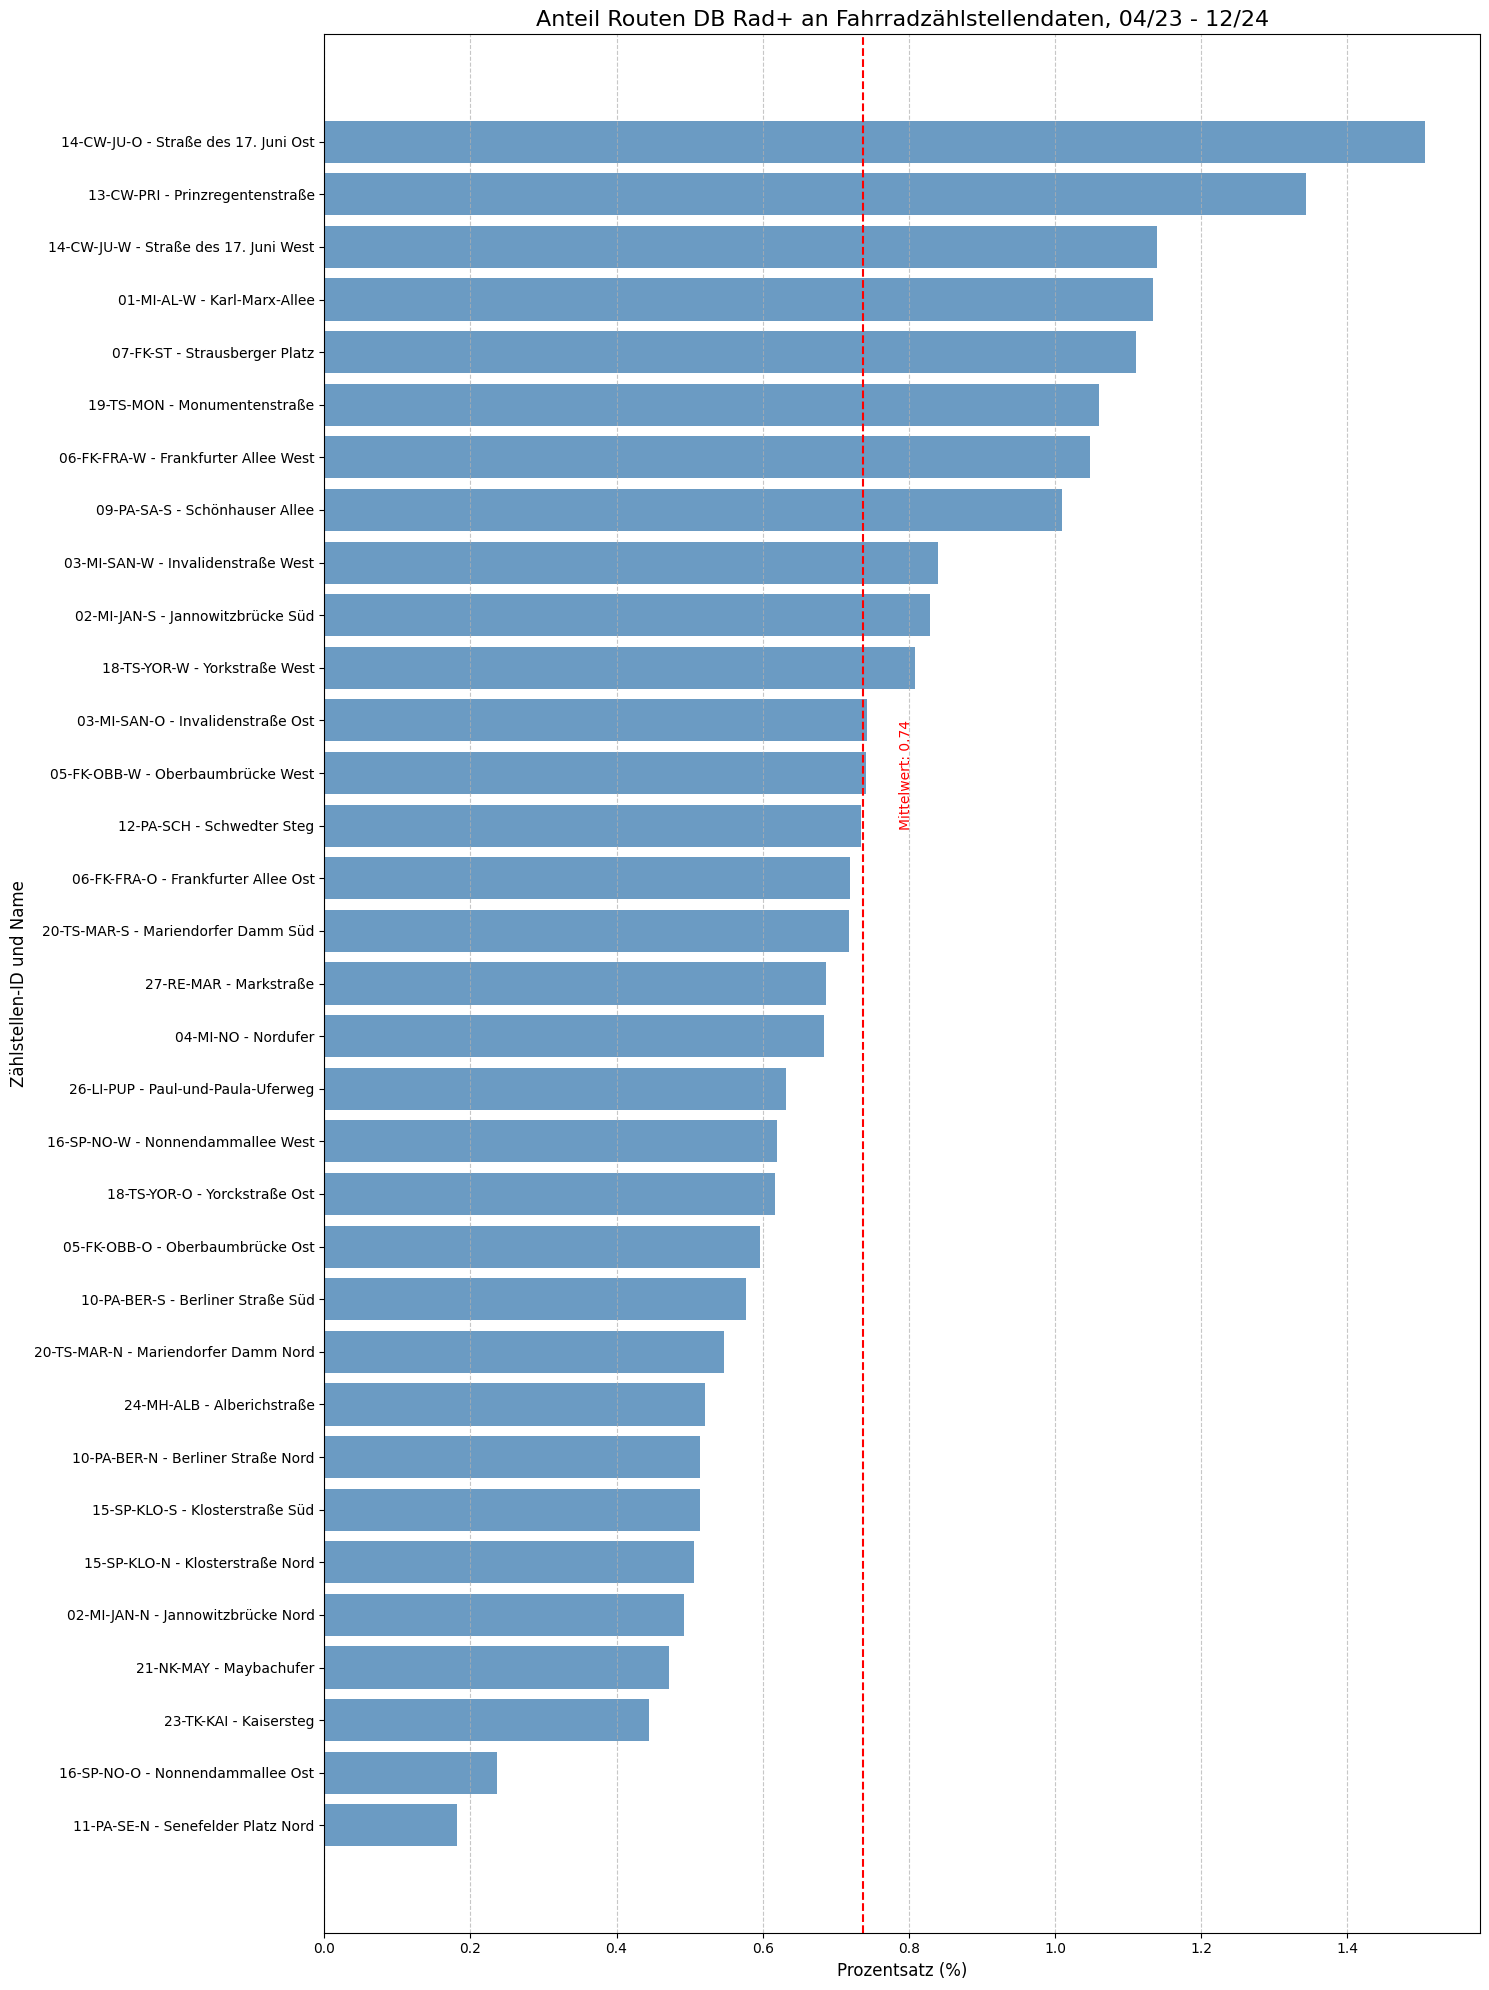

In [2]:
# Step 4: Einfaches Balkendiagramm erstellen aus CSV (Median)

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the output directory
output_dir = 'analysis_results/003_FZS'

# Check if the output directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Output-Verzeichnis '{output_dir}' erstellt.")
else:
    print(f"Output-Verzeichnis '{output_dir}' existiert bereits.")

# Read the data
df = pd.read_csv('data/master_representativeness_for_qgis.csv')

# Mapping from station IDs to nice names
station_name_mapping = {
    '12-PA-SCH': 'Schwedter Steg',
    '02-MI-JAN-N': 'Jannowitzbrücke Nord',
    '02-MI-JAN-S': 'Jannowitzbrücke Süd',
    '13-CW-PRI': 'Prinzregentenstraße',
    '18-TS-YOR-O': 'Yorckstraße Ost',
    '18-TS-YOR-W': 'Yorkstraße West',
    '19-TS-MON': 'Monumentenstraße',
    '27-RE-MAR': 'Markstraße',
    '03-MI-SAN-O': 'Invalidenstraße Ost',
    '03-MI-SAN-W': 'Invalidenstraße West',
    '05-FK-OBB-O': 'Oberbaumbrücke Ost',
    '05-FK-OBB-W': 'Oberbaumbrücke West',
    '26-LI-PUP': 'Paul-und-Paula-Uferweg',
    '24-MH-ALB': 'Alberichstraße',
    '10-PA-BER-N': 'Berliner Straße Nord',
    '10-PA-BER-S': 'Berliner Straße Süd',
    '15-SP-KLO-S': 'Klosterstraße Süd',
    '15-SP-KLO-N': 'Klosterstraße Nord',
    '17-SK-BRE-O': 'Breitenbachplatz Ost',
    '17-SK-BRE-W': 'Breitenbachplatz West',
    '20-TS-MAR-N': 'Mariendorfer Damm Nord',
    '20-TS-MAR-S': 'Mariendorfer Damm Süd',
    '21-NK-MAY': 'Maybachufer',
    '23-TK-KAI': 'Kaisersteg',
    '06-FK-FRA-O': 'Frankfurter Allee Ost',
    '06-FK-FRA-W': 'Frankfurter Allee West',
    '14-CW-JU-W': 'Straße des 17. Juni West',
    '14-CW-JU-O': 'Straße des 17. Juni Ost',
    '01-MI-AL-W': 'Karl-Marx-Allee',
    '11-PA-SE-N': 'Senefelder Platz Nord',
    '04-MI-NO': 'Nordufer',
    '16-SP-NO-O': 'Nonnendammallee Ost',
    '16-SP-NO-W': 'Nonnendammallee West',
    '07-FK-ST': 'Strausberger Platz',
    '09-PA-SA-S': 'Schönhauser Allee'
}

# Add nice names to the dataframe
df['nice_name'] = df['station_id'].map(station_name_mapping)

# Create combined labels for the y-axis (ID + Name)
df['label'] = df['station_id'] + ' - ' + df['nice_name']

# Sort data by stats_median in descending order
df_sorted = df.sort_values('stats_median', ascending=True)  # Changed to ascending=True for bottom-to-top order

# Calculate the mean of the medians
mean_of_medians = df['stats_median'].mean()

# Create the figure with appropriate size
plt.figure(figsize=(15, 20))  # Adjusted figure size for horizontal bars

# Create the horizontal bar chart
bars = plt.barh(df_sorted['label'], df_sorted['stats_median'], color='steelblue', alpha=0.8)

# Add a vertical line for the mean of medians
plt.axvline(x=mean_of_medians, color='red', linestyle='--', 
            label=f'Mittelwert: {mean_of_medians:.2f}')

# Add a label to the line
plt.text(mean_of_medians + 0.05, len(df) - 12, 
         f'Mittelwert: {mean_of_medians:.2f}', 
         color='red', va='top', rotation=90)

# Format the chart
plt.title('Anteil Routen DB Rad+ an Fahrradzählstellendaten, 04/23 - 12/24', fontsize=16)
plt.ylabel('Zählstellen-ID und Name', fontsize=12)
plt.xlabel('Prozentsatz (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Save the figure
output_path = os.path.join(output_dir, 'fahrrad_zahlstellen_horizontal_histogram.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Grafik gespeichert unter: {output_path}")

# Show the figure
plt.show()